In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
# load the training and test datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
batch_size = 20

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size)

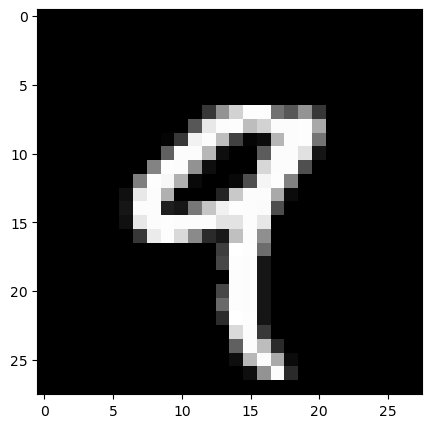

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

img = np.squeeze(images[4])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x= x.view(x.size(0),-1)
    x=self.encoder(x)
    x=self.decoder(x)
    x = x.view(x.size(0), 1, 28, 28)
    return x

# initialize the NN
model = denoising_model().to(device)
print(model)

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [7]:
n_epochs = 3

std_dev=97/255
mse=[]
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    mse_loss = 0.0
    batch_count=0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        noisy_imgs = images + std_dev * torch.randn(images.shape).to(device)
        noisy_imgs = torch.clamp(noisy_imgs, 0, 1)
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        batch_count+=1
        if batch_count%100==0:
          print('Epoch: {} \tBatch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            batch_count,
            loss.item()
            ))
          train_loss = train_loss/len(train_loader)
          mse.append(train_loss)

Epoch: 1 	Batch: 100 	Training Loss: 0.075877
Epoch: 1 	Batch: 200 	Training Loss: 0.059740
Epoch: 1 	Batch: 300 	Training Loss: 0.070501
Epoch: 1 	Batch: 400 	Training Loss: 0.061179
Epoch: 1 	Batch: 500 	Training Loss: 0.060030
Epoch: 1 	Batch: 600 	Training Loss: 0.056674
Epoch: 1 	Batch: 700 	Training Loss: 0.052655
Epoch: 1 	Batch: 800 	Training Loss: 0.042089
Epoch: 1 	Batch: 900 	Training Loss: 0.041390
Epoch: 1 	Batch: 1000 	Training Loss: 0.048559
Epoch: 1 	Batch: 1100 	Training Loss: 0.036937
Epoch: 1 	Batch: 1200 	Training Loss: 0.034854
Epoch: 1 	Batch: 1300 	Training Loss: 0.040527
Epoch: 1 	Batch: 1400 	Training Loss: 0.035286
Epoch: 1 	Batch: 1500 	Training Loss: 0.035294
Epoch: 1 	Batch: 1600 	Training Loss: 0.030877
Epoch: 1 	Batch: 1700 	Training Loss: 0.029065
Epoch: 1 	Batch: 1800 	Training Loss: 0.032052
Epoch: 1 	Batch: 1900 	Training Loss: 0.030042
Epoch: 1 	Batch: 2000 	Training Loss: 0.028146
Epoch: 1 	Batch: 2100 	Training Loss: 0.032814
Epoch: 1 	Batch: 2200 

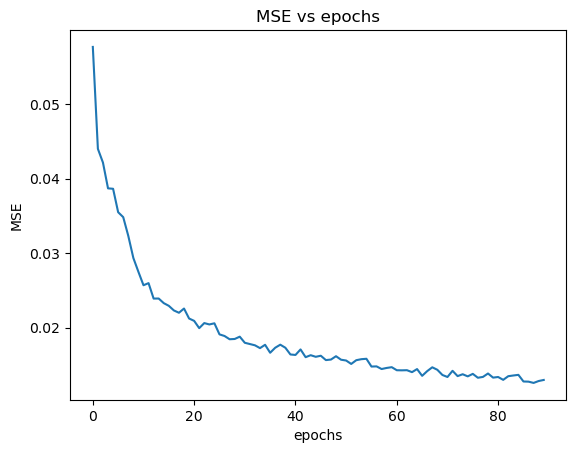

In [8]:
import matplotlib.pyplot as plt

plt.plot(mse)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('MSE vs epochs')
plt.show()


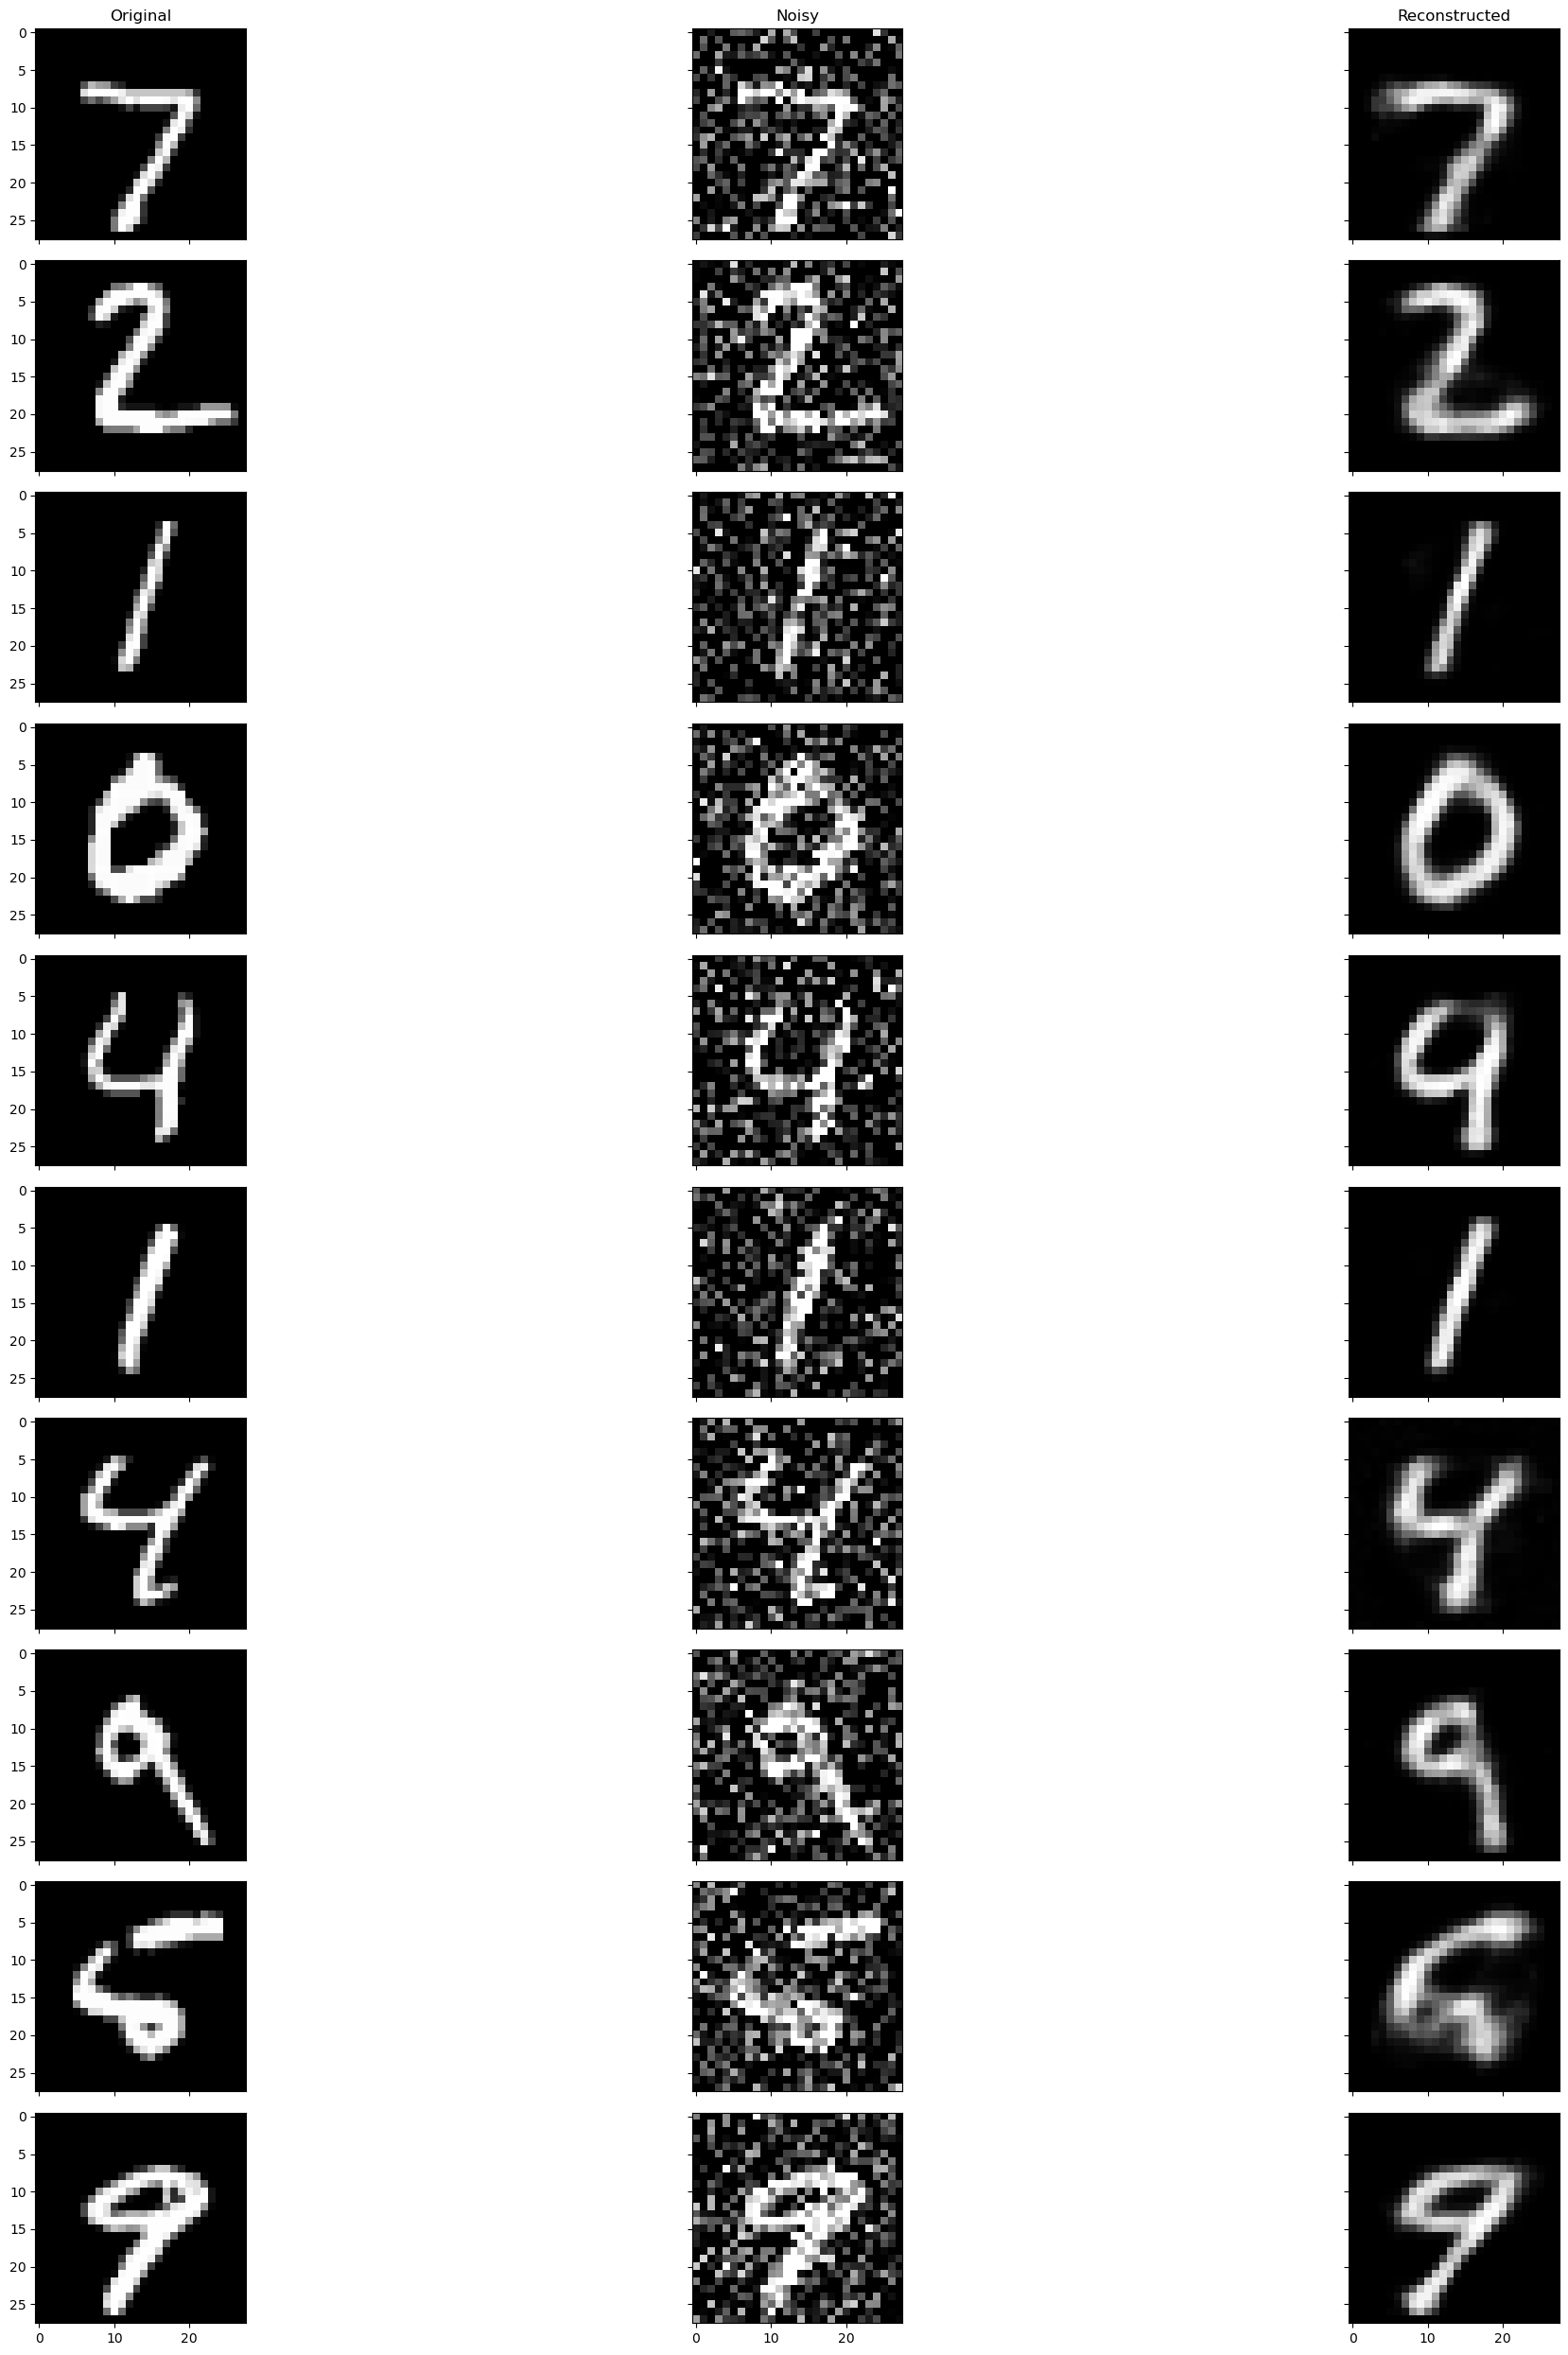

In [9]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
model.eval()
# add noise to the test images
noisy_imgs = images + std_dev * torch.randn(*images.shape).to(device)
noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
noisy_imgs = noisy_imgs.cpu().numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
output = output.detach().cpu().numpy()

images = images.cpu().numpy()

fig, axes = plt.subplots(nrows=10, ncols=3, sharex=True, sharey=True, figsize=(25, 25))
axes[0, 0].set_title('Original')
axes[0, 1].set_title('Noisy')
axes[0, 2].set_title('Reconstructed')

# actual images, noisy images, outputs
for i in range(10):
    axes[i, 0].imshow(np.squeeze(images[i]), cmap='gray')
    axes[i, 1].imshow(np.squeeze(noisy_imgs[i]), cmap='gray')
    axes[i, 2].imshow(np.squeeze(output[i]), cmap='gray')
plt.tight_layout()
plt.show()

In [10]:
# Report the MSE of the model on the test set
test_loss = 0.0
batch_count=0
for data in test_loader:
    images, _ = data
    images = images.to(device)
    noisy_imgs = images + std_dev * torch.randn(images.shape).to(device)
    noisy_imgs = torch.clamp(noisy_imgs, 0, 1)
    optimizer.zero_grad()
    outputs = model(noisy_imgs)
    loss = criterion(outputs, images)
    test_loss += loss.item()*images.size(0)
    batch_count+=1

test_loss = test_loss/len(test_loader.dataset)
print('Test MSE Loss: {:.6f}\n'.format(test_loss))


Test MSE Loss: 0.022133



In [12]:
# SAVE THE MODEL
#torch.save(model.state_dict(), 'denoising_model.pt')

